In [60]:
import pickle5 as pickle
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import numpy as np

In [2]:
#lstm generator architecture
from torch import nn
from torch.nn.utils import spectral_norm


class AddDimension(nn.Module):
    def forward(self, x):
        return x.unsqueeze(1)


class SqueezeDimension(nn.Module):
    def forward(self, x):
        return x.squeeze(1)

#Banushev
# def create_critic_architecture():
#     return nn.Sequential(nn.Conv1d(1, 32, kernel_size=1, stride=2),
#     nn.LeakyReLU(0.01),
#     nn.Conv1d(32, 64, kernel_size=1, stride=2),
#     nn.LeakyReLU(0.01),
#     nn.BatchNorm1d(64),
#     nn.Conv1d(64, 128, kernel_size=1, stride=2),
#     nn.LeakyReLU(0.01),
#     nn.BatchNorm1d(128),
#     nn.Linear (128, 220, bias=False), nn.BatchNorm1d(220), nn.LeakyReLU(0.01),
#     nn.Linear (220, 220, bias=False), nn.ReLU(),
#     nn.Linear(220, 1))
                         

def create_critic_architecture():
    return nn.Sequential(AddDimension(),
                         spectral_norm(nn.Conv1d(1, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         
                         
                         spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         

                         spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         nn.Flatten(),

                         nn.Linear(32, 50),
                         nn.LeakyReLU(0.2, inplace=True),

                         nn.Linear(50, 15),
                         nn.LeakyReLU(0.2, inplace=True),

                         nn.Linear(15, 1)
                         )


class Generator(nn.Module):
    def __init__(self, num_embed=20, num_hidden=500, num_layers=1, sequence_length=17, output_size = 1, bidirectional=False):
        
        nn.Module.__init__(self)
        
        self.num_hidden = num_hidden
        
        self.rnn = nn.LSTM(num_embed, num_hidden, num_layers, bidirectional=bidirectional)
        self.decoder = nn.Linear(num_hidden, output_size)
    
    def forward(self, inputs):
        output, hidden = self.rnn(inputs)
        decoded = self.decoder(output)
        return decoded
    


class Critic(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.main = create_critic_architecture()

    def forward(self, inputs):
        return self.main(inputs)

In [3]:
ticker_data_file = 'data/ticker_data.xlsx'
ticker_data = pd.read_excel(ticker_data_file)
tickers = ticker_data['Symbol'].to_list()
tickers_str = ''
for ticker in tickers:
    #delisted
    if (ticker != 'BRK.B'):
        tickers_str = tickers_str + ticker + ' '
tickers_str = tickers_str[:len(tickers_str)-1]
tickers.remove('BRK.B')

In [61]:
price_data = yf.download( 
        tickers = tickers_str,
        start="2015-01-01", end="2019-12-31",
        interval = "1d",
        group_by = 'ticker',
        auto_adjust = True,
        prepost = False,
        threads = True,
        proxy = None)

[*********************100%***********************]  49 of 49 completed


In [62]:
price_df = pd.DataFrame({})
for tick in tickers:
    df = price_data[tick]['Open']
    price_df[tick] = df

In [63]:
#inspect na, remove paypal
price_df.isnull().sum()
price_df = price_df.drop (['PYPL'],axis=1)

In [64]:
#technical indicators
factor_list = ['macd', 'mom', 'rsi', 'slope', 'stoch', 'sma', 'vwap', 'mad', 'stdev', 'variance', 'bbands', 'adx', 'entropy', 'stochrsi']

In [65]:
#technical indicators
factor_data = {}
for factor_name in factor_list:
    try:
        factor_df = pd.DataFrame({})
        shift = True
        for tick in price_df.columns:
            ta_df = price_data[tick]
            factor_df[tick] = getattr(ta_df.copy().ta, factor_name)()
        factor_df = factor_df.shift(int(shift))
        factor_data[factor_name] = factor_df
    except:
        continue

In [66]:
#remaining factors
print (factor_data.keys())

dict_keys(['mom', 'rsi', 'slope', 'sma', 'vwap', 'mad', 'stdev', 'variance', 'entropy'])


In [67]:
#fourier transform
fourier_df = pd.DataFrame({}, index = price_data.index)
for tick in price_df.columns:
    df = price_data[tick]['Close']
    
    fourier_df[tick] = np.fft.fft(np.asarray(df.tolist()))
# factor_df = factor_df.stack()
# factor_df.index = factor_df.index.set_names(['date', 'asset'])

In [68]:
for tick in price_df.columns:
    fft_list = fourier_df[tick]
    num = 3
    fft_list_m10= np.copy(fft_list); 
    fft_list_m10[num:-num]=0
    ifft = np.fft.ifft(fft_list_m10)
    fourier_df[tick] = ifft

In [12]:
#create data to use 
data_final = pd.DataFrame(index = price_df.index)
data_final['AAPL'] = price_df['AAPL']
for i, ticker in enumerate(price_df.columns):
    if (i < 10):
        data_final[ticker] = price_df[ticker]
        
data_final['Fourier'] = fourier_df['AAPL']
for factor in factor_data.keys():
    data_final[factor] = factor_data[factor]['AAPL']
data_final = data_final.dropna(how = 'any', axis = 0)




In [13]:
#turn data into their format
data_final_list = []
example_size = 18
for i in range (data_final.shape[0]-example_size):
    example = data_final.iloc[i:example_size+i].to_dict('series')
    for key in example.keys():
        example[key] = example[key].astype('float').to_list()
    data_final_list.append(example)

/Users/Nick/anaconda3/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:1097: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


In [14]:
data_final_list[0]

{'AAPL': [32.17826099446947,
  32.21387351061405,
  32.07854033137852,
  32.346848040220586,
  32.39433071811115,
  32.61990345530427,
  32.270865729721756,
  32.56291849618489,
  32.548670778220064,
  32.741002410997325,
  33.242002779655785,
  32.952319259523975,
  33.09241199779622,
  33.01880355977688,
  32.99268950857121,
  32.94282703953596,
  33.06391487736327,
  32.96894109135176],
 'MSFT': [60.70020019919424,
  60.92606144177757,
  60.671968547828435,
  60.80372528243056,
  60.540223237009954,
  60.62491125721106,
  60.72843155262171,
  60.73784487178129,
  60.304945495750594,
  60.35200554427572,
  60.87900744053685,
  60.22024627712669,
  60.201427172564266,
  60.408474262576114,
  60.474344459035976,
  61.349560146903414,
  61.274258390470244,
  61.18016036188074],
 'AMZN': [834.0,
  841.8400268554688,
  842.0,
  848.8400268554688,
  856.9500122070312,
  857.5700073242188,
  844.6900024414062,
  842.3800048828125,
  851.4500122070312,
  853.0499877929688,
  853.080017089843

In [ ]:
train_data_proportion = int(.8*len(data_final_list))
train_data = data_final_list[:train_data_proportion]
test_data = data_final_list[train_data_proportion:]

In [ ]:
import argparse
import os


import torch
from tqdm import tqdm
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from math import pi

In [19]:
from sklearn.metrics import mean_absolute_error
class Trainer:
    NOISE_LENGTH = 50

    def __init__(self, generator, critic, gen_optimizer, critic_optimizer,
                 gp_weight=10, critic_iterations=5, print_every=50, use_cuda=False, checkpoint_frequency=200):
        self.g = generator
        self.g_opt = gen_optimizer
        self.c = critic
        self.c_opt = critic_optimizer
        self.losses = {'g': [], 'c': [], 'GP': [], 'gradient_norm': []}
        self.num_steps = 0
        self.use_cuda = use_cuda
        self.gp_weight = gp_weight
        self.critic_iterations = critic_iterations
        self.print_every = print_every
        self.checkpoint_frequency = checkpoint_frequency

        if self.use_cuda:
            self.g.cuda()
            self.c.cuda()

    def _critic_train_iteration(self, data):
    
        #My code
        #create generator data
        data_size = len(data['AAPL']) - 1
        generator_data = []
        for key in data.keys():
            generator_data.append([t.numpy() for t in data[key][:data_size]])
        generator_data = torch.from_numpy(np.array(generator_data).astype('float64'))
        generator_data = generator_data.permute(1, 2, 0)
        
       
        #create critic data
        critic_data = torch.from_numpy(np.array([t.numpy() for t in data['AAPL'][data_size:]]).astype('float64'))
        critic_data = Variable(critic_data)
        critic_data = critic_data.permute (1, 0)
        
        
        generated_data = self.g(generator_data.float()) 
        # Get gradient penalty
#         print (generated_data.shape)
        generated_data = torch.unsqueeze(torch.squeeze(generated_data, 2).permute(1,0)[:,16], 1)

        # Pass data through the Critic
#         print (critic_data.shape)
#         print (generated_data.shape)
        
        c_real = self.c(critic_data.float())
        c_generated = self.c(generated_data.float())

#       
#         print ('here')
#         print (generated_data.shape)
#         print (critic_data.shape)

       

        gradient_penalty = self._gradient_penalty(critic_data, generated_data)
        self.losses['GP'].append(gradient_penalty.data.item())

        # Create total loss and optimize
        self.c_opt.zero_grad()
        d_loss = c_generated.mean() - c_real.mean() + gradient_penalty
        d_loss.backward()
        self.c_opt.step()

        self.losses['c'].append(d_loss.data.item())

    def _generator_train_iteration(self, data):
        self.g_opt.zero_grad()
        
        #create generator data
        data_size = len(data['AAPL']) - 1
        generator_data = []
        for key in data.keys():
            generator_data.append([t.numpy() for t in data[key][:data_size]])
        generator_data = torch.from_numpy(np.array(generator_data).astype('float64'))
        generator_data = generator_data.permute(1, 2, 0)
        generator_result= self.g(generator_data.float())
        
        
        generator_result = torch.unsqueeze(torch.squeeze(generator_result, 2).permute(1,0)[:,16], 1)
        # Calculate loss and optimize
        d_generated = self.c(generator_result.float())
        g_loss = - d_generated.mean()
        g_loss.backward()
        self.g_opt.step()
        self.losses['g'].append(g_loss.data.item())

    def _gradient_penalty(self, real_data, generated_data):
        
#         print (real_data.shape)
#         print (generated_data.shape)
        batch_size = real_data.size()[0]

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1)
        alpha = alpha.expand_as(real_data)
        if self.use_cuda:
            alpha = alpha.cuda()
        interpolated = alpha * real_data + (1 - alpha) * generated_data
        interpolated = Variable(interpolated, requires_grad=True)
#         print (interpolated.shape)
        if self.use_cuda:
            interpolated = interpolated.cuda()

        # Pass interpolated data through Critic
        prob_interpolated = self.c(interpolated.float())

        # Calculate gradients of probabilities with respect to examples
        gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda() if self.use_cuda
                               else torch.ones(prob_interpolated.size()), create_graph=True,
                               retain_graph=True)[0]
        # Gradients have shape (batch_size, num_channels, series length),
        # here we flatten to take the norm per example for every batch
        gradients = gradients.view(batch_size, -1)
        self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data.item())

        # Derivatives of the gradient close to 0 can cause problems because of the
        # square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return self.gp_weight * ((gradients_norm - 1) ** 2).mean()

    def _train_epoch(self, data_loader, epoch, writer):
        for i, data in enumerate(data_loader):
            
            #my code 
            data_size = 100
            #print (len(data['AAPL']))
            
            
            self.num_steps += 1
            self._critic_train_iteration(data)
            # Only update generator every critic_iterations iterations
            if self.num_steps % self.critic_iterations == 0:
                self._generator_train_iteration(data)

            if i % self.print_every == 0:
                global_step = i + epoch * len(data_loader.dataset)
                writer.add_scalar('Losses/Critic', self.losses['c'][-1], global_step)
                writer.add_scalar('Losses/Gradient Penalty', self.losses['GP'][-1], global_step)
                writer.add_scalar('Gradient Norm', self.losses['gradient_norm'][-1], global_step)

                if self.num_steps > self.critic_iterations:
                    writer.add_scalar('Losses/Generator', self.losses['g'][-1], global_step)

    def train(self, data_loader, data_list, epochs, plot_training_samples=True, checkpoint=None, writer=None):
        
        eval_data = []
        for data in test_data:
            generator_data = []
            for key in data.keys():
                generator_data.append(data[key])
            generator_data = torch.from_numpy(np.array(generator_data).astype('float64'))
            generator_data = torch.unsqueeze (generator_data, 0)
            data_cur = generator_data.permute(2, 0, 1)
            eval_data.append(data_cur)
        
        if checkpoint:
            path = os.path.join('checkpoints', checkpoint)
            state_dicts = torch.load(path, map_location=torch.device('cpu'))
            self.g.load_state_dict(state_dicts['g_state_dict'])
            self.c.load_state_dict(state_dicts['d_state_dict'])
            self.g_opt.load_state_dict(state_dicts['g_opt_state_dict'])
            self.c_opt.load_state_dict(state_dicts['d_opt_state_dict'])
       
#         # Define noise_shape
#         noise_shape = (1, self.NOISE_LENGTH)
        
#         if plot_training_samples:
#             # Fix latents to see how series generation improves during training
#             fixed_latents = Variable(self.sample_latent(noise_shape))
#             if self.use_cuda:
#                 fixed_latents = fixed_latents.cuda()

        #my code
        self.g = self.g.float()
        self.c = self.c.float()
        
        returns_generated = []
        returns_true = []
        MAE_list = []
        
        for epoch in tqdm(range(epochs)):

#             # Sample a different region of the latent distribution to check for mode collapse
#             dynamic_latents = Variable(self.sample_latent(noise_shape))
#             if self.use_cuda:
#                 dynamic_latents = dynamic_latents.cuda()

            self._train_epoch(data_loader, epoch + 1, writer)

#             # Save checkpoint
#             if epoch % self.checkpoint_frequency == 0:
#                 torch.save({
#                     'epoch': epoch,
#                     'd_state_dict': self.c.state_dict(),
#                     'g_state_dict': self.g.state_dict(),
#                     'd_opt_state_dict': self.c_opt.state_dict(),
#                     'g_opt_state_dict': self.g_opt.state_dict(),
#                 }, 'checkpoints/epoch_{}.pkl'.format(epoch))

            if plot_training_samples and (epoch % self.print_every == 0):
                self.g.eval()
            
                # Generate eval result (last sample period)
                returns_generated = []
                returns_true = []
                for data in eval_data:
                    train = data[:17, :, :]
                    true_val = data[17, :, 0]
                    generator_result= self.g(train.float())
                    generator_result = torch.squeeze(generator_result, 2).permute(1,0)[:,16]
                    returns_generated.append(generator_result.detach().numpy()[0])
                    returns_true.append(true_val.numpy()[0])
                MAE = mean_absolute_error(returns_true, returns_generated)
                MAE_list.append(MAE)
                    
                print ("MAE")
                print (MAE)
                print ()
                
                plt.figure()
                plt.plot(returns_generated, label = 'generated')
                plt.plot (returns_true, label = 'true')
                plt.show()
                #plt.savefig('training_samples/fixed_latents/series_epoch_{}.png'.format(epoch))
                plt.close()

#                 plt.figure()
#                 plt.plot(fake_data_dynamic_latents.numpy()[0].T)
#                 #plt.savefig('training_samples/dynamic_latents/series_epoch_{}.png'.format(epoch))
#                 plt.show()
#                 plt.close()
                self.g.train()
        return returns_generated, returns_true
#     def sample_generator(self, latent_shape):
#         latent_samples = Variable(self.sample_latent(latent_shape))
#         if self.use_cuda:
#             latent_samples = latent_samples.cuda()

#         return self.g(latent_samples)

    @staticmethod
    def sample_latent(shape):
        return torch.randn(shape)

    def sample(self, num_samples):
        generated_data = self.sample_generator(num_samples)
        return generated_data.data.cpu().numpy()


def run_GAN():


    batch_size = 16
    epochs = 1400
    log_name = 'tensorboard_log_name'
    checkpoint = None
    

    # Instantiate Generator and Critic + initialize weights
    g = Generator()

    g_opt = torch.optim.RMSprop(g.parameters(), lr=0.00005)
    d = Critic()

    d_opt = torch.optim.RMSprop(d.parameters(), lr=0.00005)
    
    #Create Dataloader
    dataset = train_data
    dataloader = DataLoader(dataset, batch_size=batch_size)


    # Instantiate Trainer
    trainer = Trainer(g, d, g_opt, d_opt, use_cuda=torch.cuda.is_available())
    # Train model
    print('Training is about to start...')
    # Instantiate Tensorboard writer
    tb_logdir = os.path.join('..', 'tensorboard', log_name)
    writer = SummaryWriter(tb_logdir)

    returns = trainer.train(dataloader, data_final_list, epochs=epochs, plot_training_samples=True, checkpoint=checkpoint, writer=writer)
    return returns


  0%|          | 0/1400 [00:00<?, ?it/s]

Training is about to start...
MAE
40.812370384231095



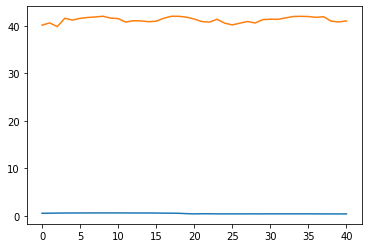


  4%|▎         | 50/1400 [02:21<1:02:46,  2.79s/it]

MAE
36.05050813386814



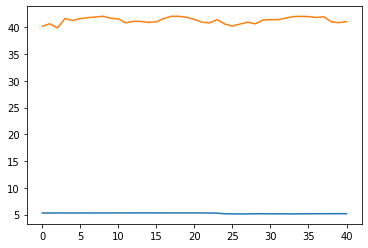


  7%|▋         | 100/1400 [04:36<59:20,  2.74s/it]

MAE
34.21581364366801



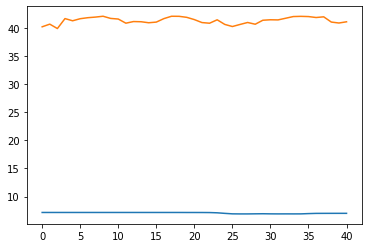


 11%|█         | 150/1400 [06:50<56:35,  2.72s/it]

MAE
32.69457468861221



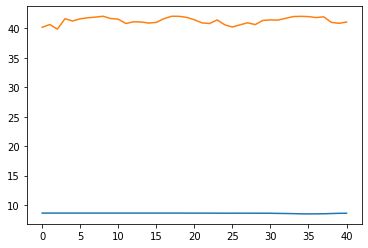


 14%|█▍        | 200/1400 [09:05<55:20,  2.77s/it]

MAE
31.463795505992046



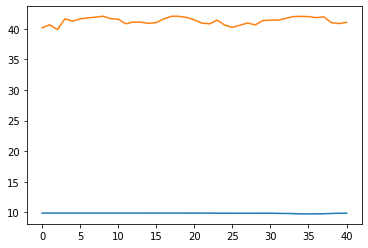


 18%|█▊        | 250/1400 [11:21<51:12,  2.67s/it]

MAE
30.42359931983333



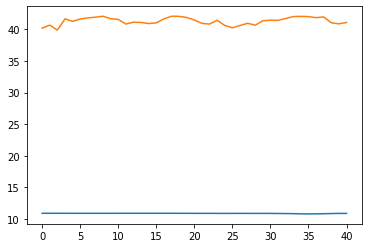


 21%|██▏       | 300/1400 [13:37<50:34,  2.76s/it]

MAE
29.404722918443813



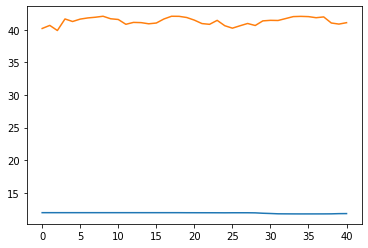


 25%|██▌       | 350/1400 [15:51<48:13,  2.76s/it]

MAE
28.4070397422636



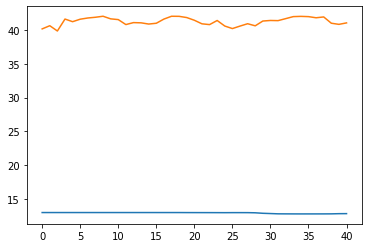


 29%|██▊       | 400/1400 [18:09<47:01,  2.82s/it]

MAE
27.400388933882727



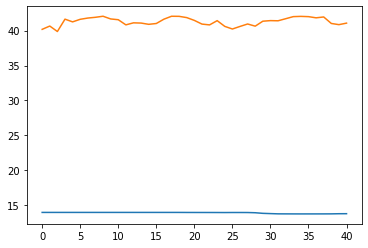


 32%|███▏      | 450/1400 [20:29<42:46,  2.70s/it]

MAE
26.370472961428938



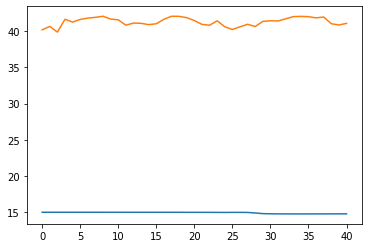


 36%|███▌      | 500/1400 [22:46<41:09,  2.74s/it]

MAE
25.37731366730052



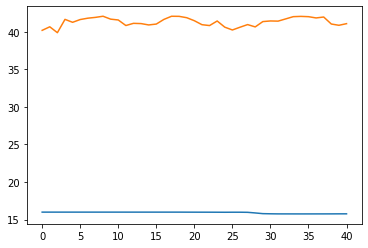


 39%|███▉      | 550/1400 [24:58<37:08,  2.62s/it]

MAE
24.393338466182236



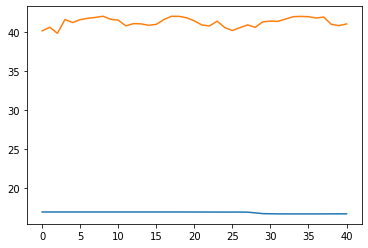


 43%|████▎     | 600/1400 [27:09<34:23,  2.58s/it]

MAE
23.392990119192905



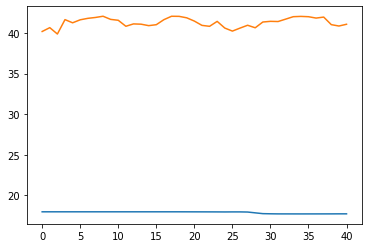


 46%|████▋     | 650/1400 [29:16<31:32,  2.52s/it]

MAE
22.41002111425948



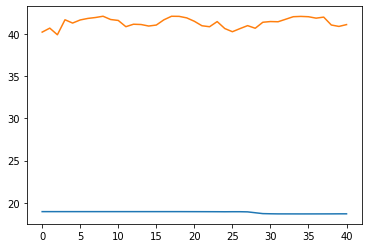


 50%|█████     | 700/1400 [31:25<30:39,  2.63s/it]

MAE
21.428180282782012



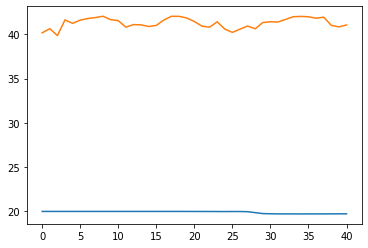


 54%|█████▎    | 750/1400 [33:36<27:42,  2.56s/it]

MAE
20.42110541497523



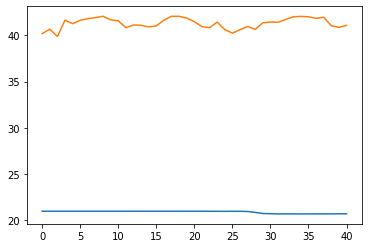


 57%|█████▋    | 800/1400 [35:45<25:46,  2.58s/it]

MAE
19.40884497796351



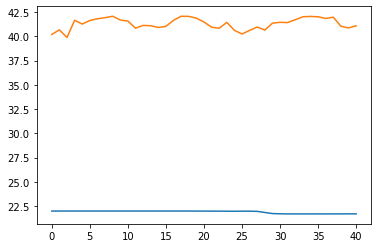


 61%|██████    | 850/1400 [37:57<23:50,  2.60s/it]

MAE
18.426262513512768



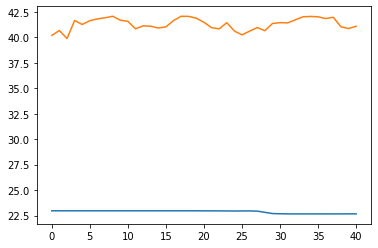


 64%|██████▍   | 900/1400 [40:06<21:28,  2.58s/it]

MAE
17.44479845317133



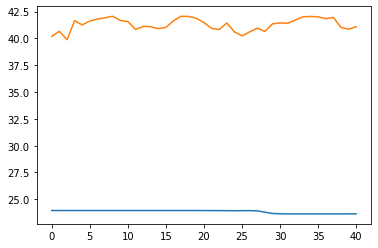


 68%|██████▊   | 950/1400 [42:11<18:50,  2.51s/it]

MAE
16.464238662164636



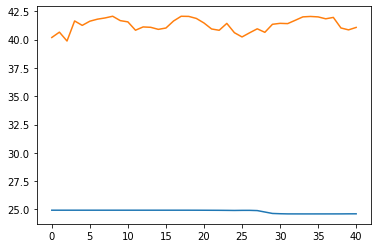


 71%|███████▏  | 1000/1400 [44:19<16:59,  2.55s/it]

MAE
15.484574673725586



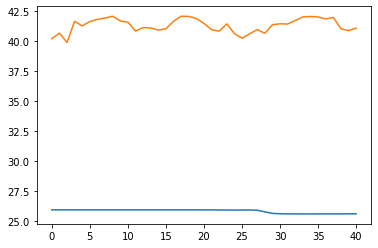


 75%|███████▌  | 1050/1400 [46:25<14:57,  2.56s/it]

MAE
14.50584230879192



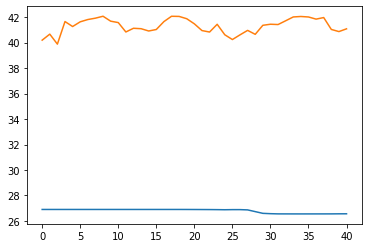


 79%|███████▊  | 1100/1400 [48:33<13:03,  2.61s/it]

MAE
13.51918942279666



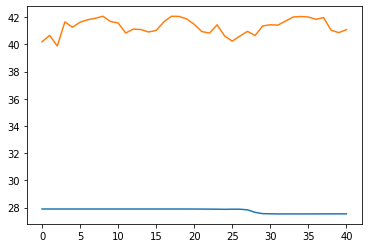


 82%|████████▏ | 1150/1400 [50:44<10:37,  2.55s/it]

MAE
12.536358956502957



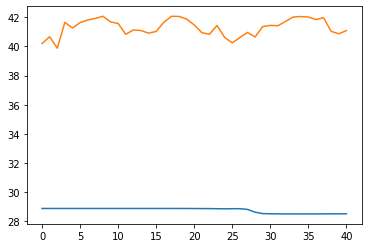


 86%|████████▌ | 1200/1400 [52:51<08:13,  2.47s/it]

MAE
11.555535439657254



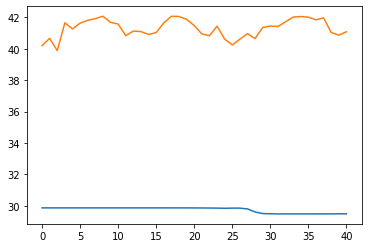


 89%|████████▉ | 1250/1400 [54:57<06:18,  2.52s/it]

MAE
10.57614894718393



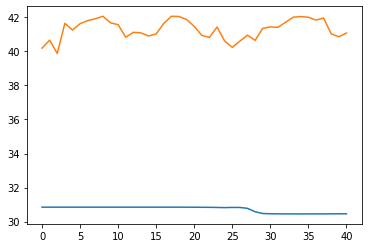


 93%|█████████▎| 1300/1400 [57:03<04:18,  2.58s/it]

MAE
9.59814970193574



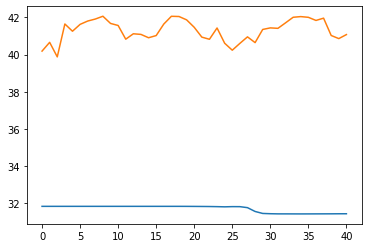


 96%|█████████▋| 1350/1400 [59:11<02:12,  2.65s/it]

MAE
8.621506953731066



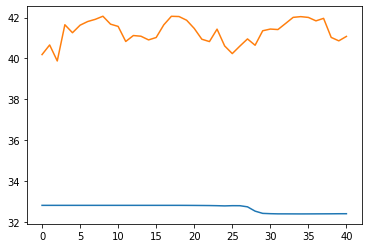


100%|██████████| 1400/1400 [1:01:22<00:00,  2.63s/it]


In [20]:
returns = run_GAN()

In [36]:
returns_generated = returns[0]
returns_true = returns[1]

In [69]:
returns_generated

[32.811787,
 32.811787,
 32.811787,
 32.811787,
 32.811787,
 32.811787,
 32.811787,
 32.811787,
 32.811787,
 32.811787,
 32.811787,
 32.811787,
 32.811787,
 32.811787,
 32.811787,
 32.811783,
 32.811775,
 32.81177,
 32.81174,
 32.81038,
 32.80804,
 32.80519,
 32.801865,
 32.794926,
 32.784843,
 32.795666,
 32.794277,
 32.739216,
 32.52828,
 32.41894,
 32.403946,
 32.395496,
 32.395096,
 32.393826,
 32.39254,
 32.393658,
 32.39529,
 32.39684,
 32.398376,
 32.401432,
 32.402203]

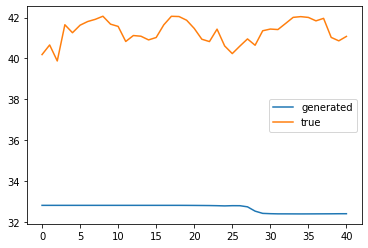

In [39]:
plt.plot(returns_generated, label = 'generated')
plt.plot(returns_true, label = 'true')
plt.legend()

In [40]:
#MAE
mean_absolute_error(returns_generated, returns_true)

8.621506953731066

In [42]:
returns_percent_generated

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.1625997e-07,
 -2.3251997e-07,
 -1.1626001e-07,
 -9.3008015e-07,
 -4.1504867e-05,
 -7.127042e-05,
 -8.685611e-05,
 -0.00010139908,
 -0.00021154086,
 -0.00030743307,
 0.0003301006,
 -4.233943e-05,
 -0.0016789923,
 -0.0064429613,
 -0.0033612861,
 -0.00046255597,
 -0.00026075696,
 -1.2364164e-05,
 -3.9212548e-05,
 -3.9685125e-05,
 3.4505054e-05,
 5.0401544e-05,
 4.7808404e-05,
 4.745287e-05,
 9.431252e-05,
 2.3781939e-05]

In [55]:
#calculate generated and real returns
returns_percent_generated = []
for i in range (1, len(returns_generated)):
    returns_percent_generated.append( 100*(returns_generated[i] - returns_generated[i-1])/returns_generated[i-1])
returns_percent_true= []
for i in range (1, len(returns_true)):
    returns_percent_true.append( 100*(returns_true[i] - returns_true[i-1])/returns_true[i-1])

In [56]:
#trading strategy: buy if positive, nothing if negative
strategy_returns = []
for i in range (len(returns_percent_true)-1):
    if (returns_percent_generated[i] > 0):
        strategy_returns.append(returns_percent_true[i+1])
    else:
        strategy_returns.append(0)

In [57]:
#cumualtive reeturns real
cum_ret_real = [returns_percent_true[0]]
for i in range (1,len(returns_percent_true)):
    cum_ret_real.append(cum_ret_real[i-1]+returns_percent_true[i])
print ('cum ret real')
print (cum_ret_real)

#cumulative returns
cum_ret = [strategy_returns[0]]
for i in range (1,len(strategy_returns)):
    cum_ret.append(cum_ret[i-1]+strategy_returns[i])
print ('cum ret')
print (cum_ret)

#variance
variance = np.var(strategy_returns)
print ('variance')
print (variance)

print ('sharpe real')
#sharpe real
var = np.var(returns_percent_true)
rfr = 0
sharpe = (np.average(returns_percent_true)- rfr)/var
print (sharpe)

print ('sharpe')
#sharpe
var = np.var(strategy_returns)
rfr = 0
sharpe = (np.average(strategy_returns) - rfr)/var
print (sharpe)

# #drawdown
# previous_peaks = np.maximum.accumulate(cum_ret)
# drawdown = (cum_ret-previous_peaks)/previous_peaks
# max_drawdown = np.ndarray.min(drawdown)
# print (max_drawdown)
# plt.plot(drawdown)

#turnover
turnover = 0
for pred in strategy_returns:
    if (pred > 0):
        turnover += 1
turnover = turnover/len(strategy_returns)
print (turnover)

cum ret real
[1.1733064681641532, -0.7516877211586339, 3.690100039588021, 2.7533017183661523, 3.6467342476392464, 4.077990773982704, 4.335639782424273, 4.695119570006997, 3.7757090086425884, 3.5105761669206594, 1.7364311252329154, 2.4483067697447263, 2.3665434591100762, 1.9280323451519035, 2.2157777449598357, 3.7264871394669217, 4.7301877681966005, 4.701620005687076, 4.273188348583124, 3.315059913420724, 2.040654144682499, 1.7590245553698498, 3.2476893987404685, 1.2648497595893629, 0.342099672550238, 1.2555395958316669, 2.1192876352375816, 1.3626464887800183, 3.106144172986148, 3.309462577173208, 3.251486182214609, 3.96494712663499, 4.6848815690227825, 4.7706418461024045, 4.679216868635631, 4.2789312729031685, 4.571745484419236, 2.35053385947342, 1.9407080459582797, 2.46980155935781]
cum ret
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9134399232814288, 0.9134399232814288, 0.9134399232814288, 0.9134399232814288, 0.9134399232814288, 0.9134399232814288, 0.91

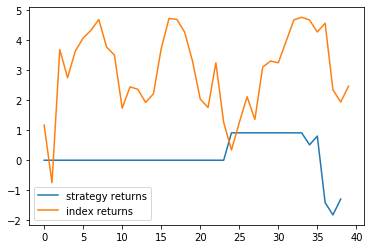

In [58]:
plt.plot(cum_ret, label = 'strategy returns')
plt.plot(cum_ret_real, label = 'index returns')
plt.legend()

In [612]:
sharpe = (np.average(strategy_returns) - 1 - rfr)/std
print (sharpe)



-96.55731129591832


In [618]:
np.var(strategy_returns)*100

0.010692395144771674

In [614]:
std

0.010340403833879833